# HW 2 - Drag and Airfoils

Eduardo Alvarez, 20170927

## Prompt 1

__PROMPT:__ Create a function to compute the total drag of your aircraft during steady, level flight.

The lift required will be equal to the weight of the aircraft, hence, let's parameterized the weight as a function of geometric parameter. 

First off, we have the following base weights:

<strong>Component &nbsp; &nbsp;Estimated Weight (grams/each)</strong><br>ESC (2): &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 9<br>BEC (1): &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 16<br>Raspberry Pi 3&nbsp;(1): 47<br>Flip32&nbsp;(1): &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 14<br>Battery&nbsp;(1): &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 36<br>Propeller&nbsp;(1): &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;3<br>GPS&nbsp;(1): &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 32<br>Motor&nbsp;(2): &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15<br>Servos (2-4): &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;9<br>Wires, connectors, etc throughout plane: &nbsp;50</p>


The geometry of the aircraft is then parameterized as follows:

<img src="img/canard00.png" alt="Pic here" style="width:700px">

Where the fuselage is a hollow body made of cloroplast sheet ($\rho_c = 1.5 \text{ kg/m}^2$), and wing, canard, and tail are made out of HD EPS foam ($\rho_f = 32 \text{ kg/m}^3$)

In [1]:
# Cloropast density http://www.homedepot.com/p/Coroplast-48-in-x-96-in-x-0-157-in-White-Corrugated-Plastic-Sheet-CP4896S/205351385
println(9.8/(96*48) * (0.453592/0.00064516))
# EPP density  http://www.rcplanesguru.org/2015/10/hd-foam-cutting-and-shaping.html
println(2*16.0185)

1.4952422439567103
32.037


Hence, the weight of fuselage ($M_f$), wing ($M_w$), canard ($M_c$), and vertical tail ($M_t$) will be calculated as 

\begin{align}
        \bullet \quad & M_f = \rho_c \pi d l
    \\
        \bullet \quad & M_w = 2 \rho_f \Big[ (\frac{c_{wt}+c_{wr}}{2}) \frac{b_w/2}{\cos\Lambda_w} (\frac{c_{wt}+c_{wr}}{2})0.5 t_w^* \Big]
    \\ & \qquad = \rho_f \frac{b_w/2}{\cos\Lambda_w} (\frac{c_{wt}+c_{wr}}{2})^2t_w^{*}
    \\
        \bullet \quad & M_c = \rho_f \frac{b_c/2}{\cos\Lambda_c} (\frac{c_{ct}+c_{cr}}{2})^2t_c^*
    \\
        \bullet \quad & M_t = \rho_f \frac{l_r+l_t}{2}h t_t
\end{align}


In [11]:
using PyPlot

# ------ CONSTANTS
g = 9.82          # (m/s^2) gravity
rhoinf = 1.225    # (kg/m^3) air density at sea level and 15Cdegs
mu = 1.846/10^5   # (kg/m*s) air dynamic viscosity

# ------ MATERIALS
rho_c = 1.5       # (kg/m^2) Cloroplast area density
rho_f = 32        # (kg/m^3) HD EPS foam density

# ------ GEOMETRIC PARAMETERS
# Fuselage
d = 0.15        # (m) diameter 
l = 1.75           # (m) length
# Wing
b_w = 1.0       # (m) span
lambda_w = 5*pi/180        # (rad) sweep
c_wtip = 0.08     # (m) tip chord
c_wroot = 0.08    # (m) root chord
t_w = 0.1         # (ratio) ave max thickness/chord
barc_w = (c_wtip+c_wroot)/2
# canard
b_c = 0.00001     # (m) span
lambda_c = 0*pi/180        # (rad) sweep
c_ctip = 0.10     # (m) tip chord
c_croot = 0.10    # (m) root chord
t_c = 0.15        # (ratio) ave max thickness/chord
barc_c = (c_ctip+c_croot)/2
# vertical tail
h_t = 0.000001        # (m) height
l_troot = 0.35    # (m) root length
l_ttip = l_troot/3# (m) tip length
t_t = 0.04        # (m) thickness
barc_t = (l_ttip+l_troot)/2

Sref = 0.0833     # Reference area

# ------ USEFUL FUNCTIONS
calc_Re(Vinf, l) = rhoinf*Vinf*l/mu
calc_qinf(Vinf) = 1/2*rhoinf*Vinf.^2
Vinfmin, Vinfmax = 3, 20 # (m/s)


# ------ ASSUMPTIONS
CLratio = 0.00001    # CLcanard/CLwing

M_base = (9*2 + 16 + 47 + 14 + 36 + 3 + 32 + 15*2 + 9*4 + 50)/1000
M_f = rho_c * pi*d*l
M_w = rho_f * b_w/2/cos(lambda_w) * barc_w^2 * t_w
M_c = rho_f * b_c/2/cos(lambda_c) * barc_c^2 * t_c
M_t = rho_f * barc_t * h_t*t_t

# Mtot = sum([M_base, M_f, M_w, M_c, M_t])
Mtot = .56
L = Mtot*g
println("Total mass: $Mtot (kg)")
println("Lift required: $L (N)")

Total mass: 0.56 (kg)
Lift required: 5.499200000000001 (N)


The drag will be broken down into parasitic drag ($D_p$) and lifting drag ($D_i$) with components as follow:

\begin{align}
    \bullet \quad & D_p = (D_p)_f + (D_p)_w + (D_p)_c + (D_p)_t
    \\
    \bullet \quad & D_i = (D_i)_w + (D_i)_c + (D_i)_t
\end{align}

with subindices $f,w,c,t$ indicating fuselage, wing, canard, and tail, respectively.

Verifying the Cf function with a discontinuous step between laminar and turbulent:

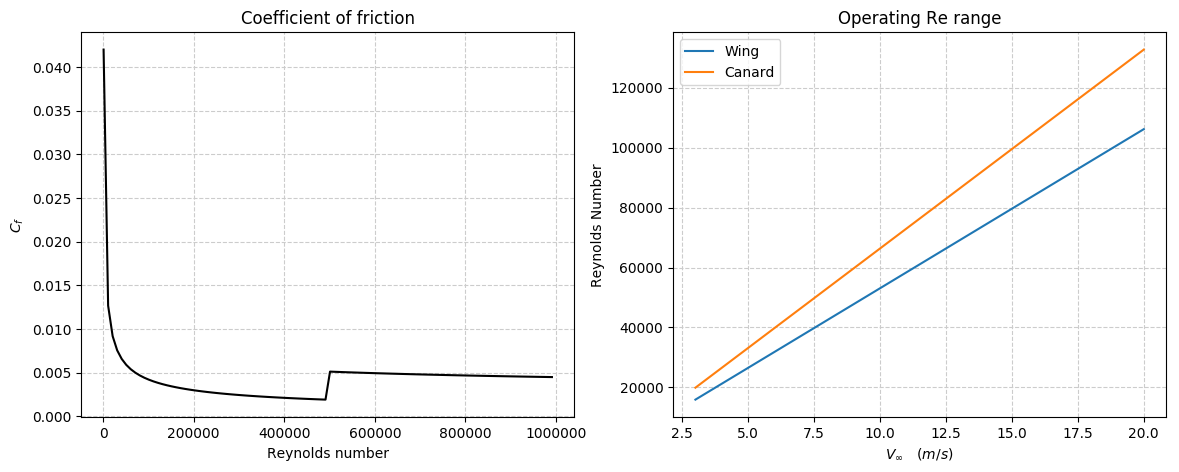

PyObject <matplotlib.legend.Legend object at 0x7fca253f8210>

In [12]:
# Coefficient of friction, Cf = tau / qinf
Cf_lam(Re) = 1.328/sqrt(Re)              # Average coeff laminar flow over flat plate
Cf_tur(Re) = 0.455/(log10(Re))^(2.58)    # Average coeff turbulent flow over flat plate
Cf(Re) = Re<5*10^5 ? Cf_lam(Re) : Cf_tur(Re)
# Form factors
k_lift(t_over_c, sweep) = 1 + 2*cos(sweep)*t_over_c + 100*(t_over_c)^4        # Lifting surface
k_revbody(l_over_d) = l_over_d<15 ? 1.675-0.09*l_over_d+0.003*l_over_d^2 : 1  # Body of revolution

fig = figure("Cf_Re", figsize=(7*2,5*1))

subplot(121)
x = [xi for xi in 1000:10^6/100:10^6]
y = [Cf(xi) for xi in x]
plot(x,y, "k""")
grid(true, color="0.8", linestyle="--")
xlabel("Reynolds number")
ylabel(L"C_f")
title("Coefficient of friction")

subplot(122)
x = [Vinf for Vinf in Vinfmin:0.5:Vinfmax]
for (label, lref) in [("Wing", barc_w), ("Canard", barc_c)]
    y = [calc_Re(Vinf, lref) for Vinf in x]
    plot(x,y, label=label)
end
grid(true, color="0.8", linestyle="--")
xlabel(L"V_\infty \quad (m/s)")
ylabel("Reynolds Number")
title("Operating Re range")
legend(loc="best")

This is how parasitic drag ($C_{Dp}$) will be calculated:

In [13]:

function calc_CDp(Vinf)
    
    qinf = calc_qinf(Vinf)
    
    # Fuselage
    CDp_f = k_revbody(l/d) * Cf(calc_Re(Vinf, l)) * (pi*d*l)/Sref
    # Wing
    Sexp_w = 2*( (b_w/2/cos(lambda_w) - d/2 )*(c_wtip+c_wroot)/2 )
    CDp_w = k_lift(t_w, lambda_w) * Cf(calc_Re(Vinf, (c_wtip+c_wroot)/2)) * (
                            2*(1+0.2*t_w)*Sexp_w)/Sref
    # Canard
    Sexp_c = 2*( (b_c/2/cos(lambda_c) - d/2 )*(c_ctip+c_croot)/2 )
    CDp_c = k_lift(t_c, lambda_c) * Cf(calc_Re(Vinf, (c_ctip+c_croot)/2)) * (
                            2*(1+0.2*t_c)*Sexp_c)/Sref
    # Horizontal tail
    tail_t_over_c = t_t/((l_ttip+l_troot)/2)
    lambda_tail = atan2(l_troot-l_ttip, h_t)
    Sexp_t = (h_t/cos(lambda_tail))*(l_ttip+l_troot)/2
    CDp_t = k_lift(tail_t_over_c, lambda_tail) * Cf(
                            calc_Re(Vinf, (l_ttip+l_troot)/2)) * (
                            2*(1+0.2*tail_t_over_c)*Sexp_t)/Sref
    
    return [CDp_f, CDp_w, CDp_c, CDp_t]
end



calc_CDp (generic function with 1 method)

And here is the total drag ($C_{Dtot} = C_{Di} + C_{Dp}$) is calculated:

In [14]:
function calc_CDtot(Vinf)
    qinf = calc_qinf(Vinf)
    K = 0.38
    
    # Distributing the lift between lifting bodies
    CL = L / (qinf*Sref)
    CL_t = 0
    CL_c = CL*CLratio
    CL_w = CL - (CL_t+CL_c)
    
    # Parasitic drag
    CDp = calc_CDp(Vinf)
    CDp_f, CDp_w, CDp_c, CDp_t = CDp
    
    # Induced drag
    ## Wing
    einv = 0.99*(1-2*(d/b_w)^2)
    AR = b_w / ((c_wtip+c_wroot)/2)
    CDiv_w = K*CDp_w*CL_w^2
    CDi_w = CL_w^2/(pi*AR*einv) + CDiv_w
    ## Canard
    einv = 0.99*(1-2*(d/b_c)^2)
    AR = b_c / ((c_ctip+c_croot)/2)
    CDiv_c = K*CDp_c*CL_c^2
    CDi_c = CL_c^2/(pi*AR*einv) + CDiv_c
    ## Vertical tail
    einv = 0.99
    AR = h_t / ((l_ttip+l_troot)/2)
    CDiv_t = K*CDp_t*CL_t^2
    CDi_t = CL_t^2/(pi*AR*einv) + CDiv_t
    
    return [0.0, CDi_w, CDi_c, CDi_t] + CDp
end


calc_CDtot (generic function with 1 method)

Verifying both formulas:

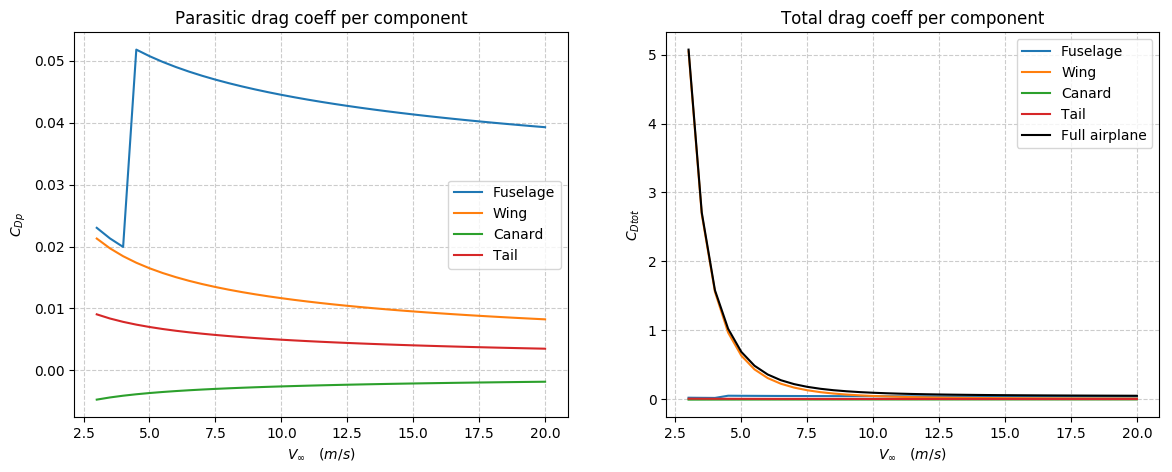

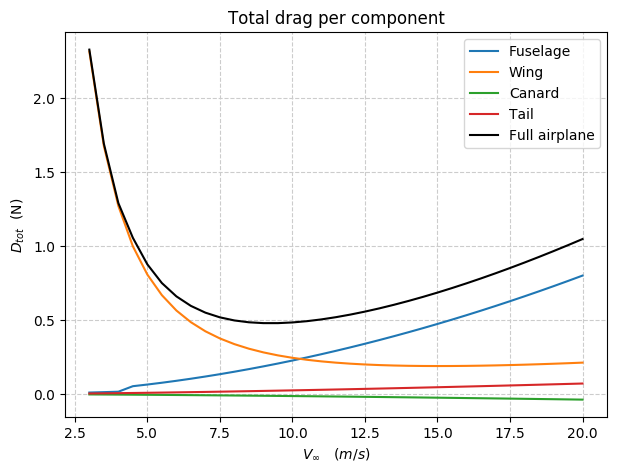

[5.07152,2.70981,1.58222,1.02282,0.68765,0.486491,0.359783,0.276677,0.220263,0.180812,0.152497,0.131701,0.116111,0.104202,0.0949515,0.0876529,0.0818115,0.077074,0.0731842,0.0699533,0.0672406,0.0649399,0.0629699,0.0612679,0.0597851,0.058483,0.0573309,0.0563046,0.0553842,0.0545536,0.0537999,0.0531122,0.0524815,0.0519005,0.0513627]


In [15]:
using PyPlot

fig = figure("CDs", figsize=(7*2,5*1))
x = [Vinf for Vinf in Vinfmin:0.5:Vinfmax]
labels = ["Fuselage", "Wing", "Canard", "Tail"]

subplot(121)
ys = [[], [], [], []]
for (i,Vinf) in enumerate(x)
    CDps = calc_CDp(Vinf)
    for (j,CDp) in enumerate(CDps)
        push!(ys[j], CDp)
    end
end
for (i,label) in enumerate(labels)
    plot(x,ys[i], label=label)
end
grid(true, color="0.8", linestyle="--")
xlabel(L"V_\infty \quad (m/s)")
ylabel(L"C_{Dp}")
title("Parasitic drag coeff per component")
legend(loc="best")

subplot(122)
ys = [[], [], [], []]
for (i,Vinf) in enumerate(x)
    CDs = calc_CDtot(Vinf)
    for (j,CD) in enumerate(CDs)
        push!(ys[j], CD)
    end
end
for (i,label) in enumerate(labels)
    plot(x,ys[i], label=label)
end
y = [sum([ys[j][i] for j in 1:4]) for i in 1:size(x)[1]]
plot(x,y, "k", label="Full airplane")
grid(true, color="0.8", linestyle="--")
xlabel(L"V_\infty \quad (m/s)")
ylabel(L"C_{Dtot}")
title("Total drag coeff per component")
legend(loc="best")


fig = figure("D", figsize=(7*1,5*1))
for (i,label) in enumerate(labels)
    plot(x,ys[i].*calc_qinf(x)*Sref, label=label)
end
y = [sum([ys[j][i] for j in 1:4]) for i in 1:size(x)[1]]
plot(x,y.*calc_qinf(x)*Sref, "k", label="Full airplane")
grid(true, color="0.8", linestyle="--")
xlabel(L"V_\infty \quad (m/s)")
ylabel(L"$D_{tot} $  (N)")
title("Total drag per component")
legend(loc="best")

println(y)

Now lets plot $L/D$ vs $V\infty$

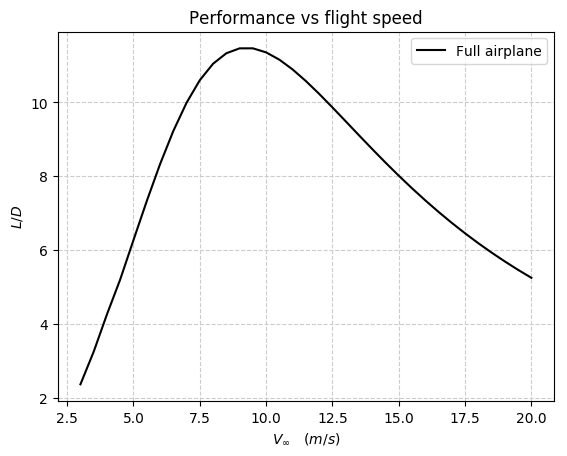

PyObject <matplotlib.legend.Legend object at 0x7fca2514d550>

In [16]:

x = [Vinf for Vinf in Vinfmin:0.5:Vinfmax]
y = [sum([ys[j][i] for j in 1:4]) for i in 1:size(x)[1]]
plot(x,L./(y.*calc_qinf(x)*Sref), "k", label="Full airplane")
grid(true, color="0.8", linestyle="--")
xlabel(L"V_\infty \quad (m/s)")
ylabel(L"L/D")
title("Performance vs flight speed")
legend(loc="best")

Hence, the optimum flight speed for this configuration is about 7 m/s, with the following performance at that such speed:

In [17]:
Vinfopt = 7.0 
CL = L/(calc_qinf(Vinfopt)*Sref)

println("Optimum flight speed: \t\t$Vinfopt (m/s)")
println("Reynolds number for main wing: \t$(round(calc_Re(Vinfopt, barc_w),0))")
println("Lift coefficient: \t\t$(round(CL,2))")
println("Max L/D: \t\t\t$(round(CL/sum(calc_CDtot(Vinfopt)),1))")

Optimum flight speed: 		7.0 (m/s)
Reynolds number for main wing: 	37161.0
Lift coefficient: 		2.2
Max L/D: 			10.0


## Prompt 2

__PROMPT:__ Assuming compressibility drag is negligible, derive an analytic expression in terms of AR, e, CDp for the lift coefficient that maximizes L/D and the corresponding max L/D.

Noticing from the previous analisis in Prompt 1 that the wing is the main source of drag, let's neglect the drag of all other components and lets compute L/D considering only the wing:

<img src="img/IMG_2980.JPG" alt="Pic here" style="width:400px">

In [9]:
Vinfopt = 7.0 
AR = b_w / ((c_wtip+c_wroot)/2) 
_, CDp_w, _, _ = calc_CDp(Vinfopt)
e = 1 / (1/0.98 + 0.38*CDp_w*pi*AR)
CLstar = sqrt(pi*AR*e*CDp_w) 
CLnum = L/(calc_qinf(Vinfopt)*Sref)

L_over_D_star = 1/2*sqrt(pi*AR*e/CDp_w)

println("Analytical optimum CL: \t$CLstar")
println("Numerical optimum CL: \t$(CLnum)")
# println("Numerical optimum CL: \t$(CLnum*(1-CLratio))")
println("")
println("Analytical max L/D: \t$(round(L_over_D_star,1))")
println("Numerical max L/D: \t$(round(CL/sum(calc_CDtot(Vinfopt)),1))")

Analytical optimum CL: 	0.6674534431125255
Numerical optimum CL: 	2.199643705878853

Analytical max L/D: 	23.9
Numerical max L/D: 	NaN


From there we notice that the analytical optimum CL differs from the numerical in about 100%, however, we must remember that the numerical calculation were carried on assuming that not all the lift is generated by the wing, it is rather distributed between the wing and the canard. Actually, we had assumed that the distributions would be $L_{ratio} = L_{canard}/L_{wing} = 0.25$, hence the numerical optimum needs to be multiplied by the factor $(1-L_{ratio})$, resulting in:

In [10]:

println("Analytical optimum CL: \t$CLstar")
println("Numerical optimum CL: \t$(CLnum*(1-CLratio))")

Analytical optimum CL: 	0.6674534431125255
Numerical optimum CL: 	2.1996217094417947


Which bring the values in closer agreement. The rest of the discrepancy is attributed to the fact the only source of drag considered in $L/D$ is the wing's drag, neglecting the drag generated by the fuselage, which the analysis on Prompt 1 showed that it was about the same order of magnitude that the wing's drag.

## Prompt 3

__PROMPT:__ Using XFOIL, compare the performance of at least three different appropriate airfoils. Plot their performance on drag polars and lift curves. Select (or design) an airfoil that is appropriate for your aircraft’s Reynolds number and lift coefficient range. Plot the geometry. Describe the rationale for your design decisions.



### NACA 0024


<img src="img/airfoil00.png" alt="Pic here" style="width:600px">
<img src="img/polar00.png" alt="Pic here" style="width:600px">

### NACA 2412


<img src="img/airfoil01.png" alt="Pic here" style="width:600px">
<img src="img/polar01.png" alt="Pic here" style="width:600px">

### NACA 0009


<img src="img/airfoil03.png" alt="Pic here" style="width:600px">
<img src="img/polar03.png" alt="Pic here" style="width:600px">

### Design decision

From the analysis in Prompt 2  we had determined that the optimum CL of our configuration is in the range 0.38-0.5 for the wing. By noticing that in a polar drag plot the line from the origin that is tanget to the curve corresponds to the point of optimum L/D of the airfoil, and that the CL associated to such point is the optimum CL for such airfoil, the optimum design decision will be to choose an airfoil where such tanget cuts the polar drag curve in the CL range 0.38-0.5. NACA 0009 meets such criterion, hence, this will be the airfoil of our wing.